# General Dependencies

In [2]:
import torch
# pip uninstall torch torchvision -y
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129 INSTALL WITH CUDA INDEX look in google for pytorch start locally
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 5070 Ti


In [3]:
__file__ = "D:/GitHub/UmAutoplay/dev_play.ipynb"

In [4]:
from pathlib import Path
from core.settings import Settings
from core.utils.logger import setup_uma_logging, logger_uma

param_imgsz=832
param_conf=0.65
param_iou=0.45


PROJECT_ROOT = Path(__file__).resolve().parents[0]  # adjust to your repo root
setup_uma_logging(debug=True, show_func=False)
logger_uma.info("WORKING!")

17:14:08 INFO    1204325400.py:12: WORKING!


# Setup

In [15]:
from time import sleep

from core.controllers.bluestacks import BlueStacksController
from core.controllers.steam import SteamController
from core.controllers.android import ScrcpyController

ctrl = SteamController("Umamusume", capture_client_only=True)
# ctrl = ScrcpyController(window_title="23117RA68G")
# ctrl = BlueStacksController("BlueStacks App Player")

In [16]:
from core.perception.ocr.ocr_local import LocalOCREngine

# Forcing USE_FAST_OCR=True to debug
ocr = LocalOCREngine(
    text_detection_model_name="PP-OCRv5_mobile_det",
    text_recognition_model_name="en_PP-OCRv5_mobile_rec",
)

Creating model: ('PP-OCRv5_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\PP-OCRv5_mobile_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.


17:20:54 INFO    ocr_local.py:131: OCRInterface initialized | lang=en device=cpu


In [ ]:
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.utils.waiter import Waiter,PollConfig
yolo_engine = LocalYOLOEngine(
    ctrl=ctrl,
    weights=Settings.YOLO_WEIGHTS,  # Settings.YOLO_WEIGHTS, Settings.YOLO_WEIGHTS_NAV
)
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

17:21:21 INFO    yolo_local.py:30: Loading YOLO weights from: D:\GitHub\UmAutoplay\models\uma_nav.pt


# Lookup

## Real Time

17:21:38 DEBUG   29272047.py:105: Screen Detection: Unknown | {'training_buttons': 0, 'tazuna': False, 'infirmary': False, 'rest': False, 'rest_summer': False, 'recreation': False, 'race_day': False, 'counts': {'race_team_trials': 1, 'race_events': 1, 'race_room_match': 1, 'ui_enhance': 1, 'ui_story': 1, 'ui_race': 1, 'ui_scout': 1, 'race_daily_races': 1, 'ui_home': 1}}


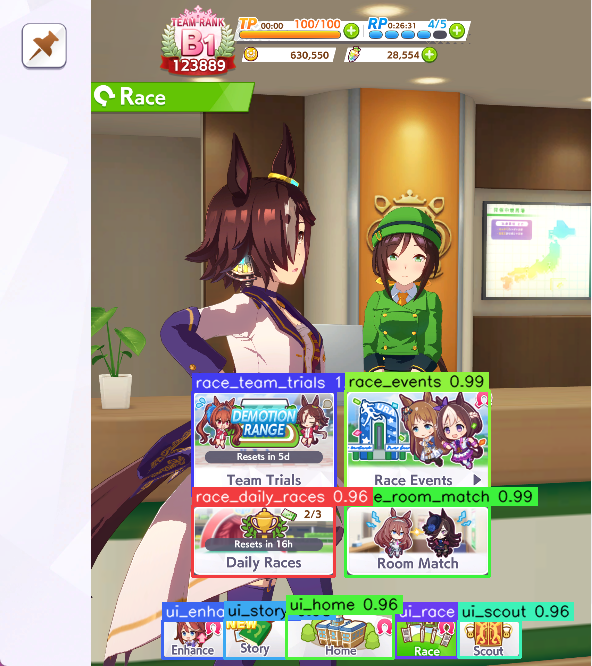

00 | race_team_trials     | conf=0.999 | xyxy=(192.7,391.4,335.5,496.4)
01 | race_events          | conf=0.995 | xyxy=(345.8,390.6,489.6,494.3)
02 | race_room_match      | conf=0.993 | xyxy=(346.0,505.7,489.3,576.3)
03 | ui_enhance           | conf=0.986 | xyxy=(162.2,620.3,224.2,658.0)
04 | ui_story             | conf=0.983 | xyxy=(225.0,619.9,286.7,658.4)
05 | ui_race              | conf=0.979 | xyxy=(395.1,620.4,457.8,657.9)
06 | ui_scout             | conf=0.958 | xyxy=(458.1,620.9,520.4,658.0)
07 | race_daily_races     | conf=0.957 | xyxy=(192.3,505.0,334.9,576.2)
08 | ui_home              | conf=0.956 | xyxy=(286.8,613.1,393.6,658.0)


In [19]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------

assert ctrl.focus()

# NEW: recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=param_imgsz,
    conf=param_conf,
    iou=param_iou,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


## Static

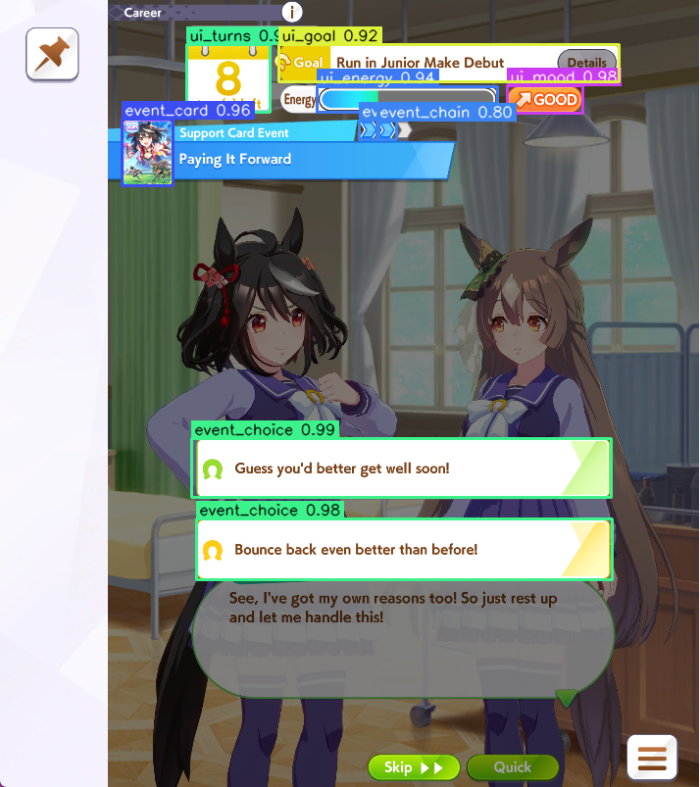

00 | event_choice         | conf=0.994 | xyxy=(195.2,447.5,623.1,507.8)
01 | event_choice         | conf=0.984 | xyxy=(200.1,529.5,624.0,591.7)
02 | ui_mood              | conf=0.978 | xyxy=(517.2,87.4,594.1,115.5)
03 | ui_turns             | conf=0.977 | xyxy=(190.6,45.2,275.9,114.2)
04 | event_card           | conf=0.960 | xyxy=(124.8,121.5,176.2,189.7)
05 | ui_energy            | conf=0.940 | xyxy=(323.5,88.8,507.8,114.4)
06 | ui_goal              | conf=0.922 | xyxy=(284.1,45.0,631.6,83.7)
07 | event_chain          | conf=0.823 | xyxy=(366.3,122.9,386.5,142.4)
08 | event_chain          | conf=0.799 | xyxy=(384.8,123.5,404.0,142.5)


In [ ]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------
from core.controllers.static_image import StaticImageController
from core.perception.yolo.yolo_local import LocalYOLOEngine


img = Image.open("tests/data/events/event_support_kitasan_paying_it_forward.png").convert("RGB")
ctrl_static = StaticImageController(img)
yolo_engine_static = LocalYOLOEngine(
    ctrl=ctrl_static,
    weights=Settings.YOLO_WEIGHTS_NAV,  # Settings.YOLO_WEIGHTS, Settings.YOLO_WEIGHTS_NAV
)


assert ctrl_static.focus()

# recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine_static.recognize(
    imgsz=832,
    conf=0.65,
    iou=0.45,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


In [30]:
# Save segment
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Literal
from PIL import Image

def _clamp_box(x1: int, y1: int, x2: int, y2: int, w: int, h: int) -> Tuple[int, int, int, int]:
    x1 = max(0, min(x1, w - 1))
    y1 = max(0, min(y1, h - 1))
    x2 = max(0, min(x2, w - 1))
    y2 = max(0, min(y2, h - 1))
    # Ensure x2>x1 and y2>y1 (at least 1px box)
    if x2 <= x1: x2 = min(w - 1, x1 + 1)
    if y2 <= y1: y2 = min(h - 1, y1 + 1)
    return x1, y1, x2, y2

def _expand_box(x1: int, y1: int, x2: int, y2: int,
                w: int, h: int,
                pad_px: int = 0,
                pad_pct: float = 0.0) -> Tuple[int, int, int, int]:
    bw = max(1, x2 - x1)
    bh = max(1, y2 - y1)
    px = pad_px + int(bw * pad_pct)
    py = pad_px + int(bh * pad_pct)
    return _clamp_box(x1 - px, y1 - py, x2 + px, y2 + py, w, h)

def crop_by_class(
    pil_img: Image.Image,
    dets: List[Dict],
    class_name: str,
    out_dir: str,
    *,
    conf_min: float = 0.0,
    mode: Literal["best","all","index"] = "best",
    index: Optional[int] = None,          # used when mode="index" (0-based within filtered list)
    pad_px: int = 0,
    pad_pct: float = 0.0,                 # e.g. 0.05 → +5% of box size on all sides
    prefix: Optional[str] = None,
    fmt: str = "png",                     # "png" or "jpg"
) -> List[Tuple[str, Image.Image, Dict]]:
    """
    Find detections with name == class_name and save crops to `out_dir`.

    Returns a list of (saved_path, crop_image, det_dict) in the order saved.
    If nothing matches, returns [].

    - mode="best": only highest-confidence match
      mode="index": only the Nth match after sorting by confidence (index required)
      mode="all": save all matches (sorted by confidence desc)
    """
    # Filter & sort candidates
    cands = [d for d in (dets or []) if str(d.get("name","")) == class_name and float(d.get("conf",0.0)) >= conf_min]
    cands.sort(key=lambda d: float(d.get("conf", 0.0)), reverse=True)

    if not cands:
        return []

    if mode == "best":
        chosen = [cands[0]]
    elif mode == "index":
        if index is None or index < 0 or index >= len(cands):
            return []
        chosen = [cands[index]]
    else:  # "all"
        chosen = cands

    # Prepare output
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)
    w, h = pil_img.size

    results: List[Tuple[str, Image.Image, Dict]] = []
    for rank, d in enumerate(chosen):
        x1, y1, x2, y2 = d.get("xyxy", (0,0,0,0))
        # Round to ints
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        # Optional padding and clamp
        x1, y1, x2, y2 = _expand_box(x1, y1, x2, y2, w, h, pad_px=pad_px, pad_pct=pad_pct)

        crop = pil_img.crop((x1, y1, x2, y2))

        base = prefix or class_name
        conf = float(d.get("conf", 0.0))
        # e.g. ui_energy_rank0_0.95_0348-0090-0622-0132.png
        fname = f"{base}_rank{rank}_{conf:.2f}_{x1:04d}-{y1:04d}-{x2:04d}-{y2:04d}.{fmt.lower()}"
        save_path = str(out_path / fname)
        # Save with sane defaults
        save_kwargs = {}
        if fmt.lower() == "jpg":
            save_kwargs.update({"quality": 95, "optimize": True})
        crop.save(save_path, **save_kwargs)

        results.append((save_path, crop, d))

    return results

_ = crop_by_class(
    game_img,
    parsed_objects_screen,
    class_name="event_card",
    out_dir="assets",
    conf_min=0.60,
    mode="best",
    pad_pct=0.01,   # add ~X% padding for safety
)


# Segment by segment testing

## Skills

In [ ]:
from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

ctrl = SteamController("Umamusume", capture_client_only=True)
assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

skills_flow = SkillsFlow(ctrl, ocr, yolo_engine, waiter)
skills_flow.buy(skill_list=[
    "Focus"
])


## Races

In [ ]:
from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

ctrl = SteamController("Umamusume", capture_client_only=True)
assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

race_flow = RaceFlow(ctrl, ocr, yolo_engine, waiter)
# race_flow._ensure_in_raceday()
# race_flow.run(ensure_navigation=False, select_style="pace")
race_flow.lobby()

## Events

In [4]:
# 🔧 Build (re-run only when you change datasets or add new images)
from core.utils.event_processor import build_catalog

from IPython.display import display
from PIL import Image
import json

def show_image(path, title=None, max_size=160):
    if not path:
        print("(no image)")
        return
    try:
        im = Image.open(path).convert("RGB")
        # shrink for notebook
        w, h = im.size
        scale = min(max_size / max(w, h), 1.0)
        if scale < 1.0:
            im = im.resize((int(w*scale), int(h*scale)))
        if title:
            print(title)
        display(im)
    except Exception as e:
        print(f"[show_image] failed: {e} | path={path}")

def preview_option(rec, pick):
    opts = rec.options or {}
    items = opts.get(str(pick), [])
    if not items:
        print(f"(no data for option {pick})")
        return
    print(f"First outcome for option {pick}:")
    print(json.dumps(items[0], ensure_ascii=False, indent=2))


print("Building catalog…")
build_catalog()

Building catalog…
[build_catalog] Wrote 853 events → datasets\in_game\event_catalog.json


In [2]:
# 🔁 Load catalog & prefs into memory (kept in notebook state)
from core.utils.event_processor import CATALOG_JSON, USER_PREFS, Catalog, UserPrefs

cat = Catalog.load(CATALOG_JSON)
prefs = UserPrefs.load(USER_PREFS)

In [9]:
import json
import fnmatch
import os
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Dict, List, Optional, Tuple

from PIL import Image
import imagehash
from rapidfuzz import fuzz, process
from PIL.Image import Image as PILImage

# -----------------------------
# Paths (adjust if needed)
# -----------------------------
DATASETS_EVENTS = Path("datasets/in_game/events.json")
ASSETS_EVENTS_DIR = Path("assets/events")  # /{support|trainee|scenario}/<name>_<rarity>.png
BUILD_DIR = Path("build")                  # will hold event_catalog.json
CATALOG_JSON = Path("datasets/in_game/event_catalog.json")
USER_PREFS = Path("event_prefs.json")       # optional overrides


def safe_phash_from_image(img: PILImage) -> Optional[int]:
   """Compute 64-bit pHash from an in-memory PIL image."""
   try:
       ph = imagehash.phash(img)
       return int(str(ph), 16)
   except Exception:
       return None

# -----------------------------
# Utilities
# -----------------------------

def normalize_text(s: str) -> str:
    """Basic normalization robust to punctuation and spacing differences."""
    if not s:
        return ""
    # unify punctuation commonly seen in Uma text (music notes, arrows, full/half width)
    rep = {
        "≫": ">>", "«": "<<", "»": ">>", "♪": " note ",
        "☆": "*", "★": "*",
        "　": " ",  # full-width space
        "–": "-", "—": "-", "―": "-", "-": "-",
        "…": "...",
    }
    s2 = s.strip().lower()
    for k, v in rep.items():
        s2 = s2.replace(k, v)
    # collapse spaces
    while "  " in s2:
        s2 = s2.replace("  ", " ")
    return s2


def safe_phash(img_path: Path) -> Optional[int]:
    """Compute 64-bit pHash for an image path, return as python int (or None if missing)."""
    try:
        with Image.open(img_path) as im:
            ph = imagehash.phash(im)  # 64-bit by default
            return int(str(ph), 16)   # store hex→int for portability
    except Exception:
        return None


def hamming_similarity64(a_int: Optional[int], b_int: Optional[int]) -> float:
    """Return similarity in [0,1] from two 64-bit pHash integers. If any None, return 0."""
    if a_int is None or b_int is None:
        return 0.0
    # hamming distance of 64-bit integers
    # Python 3.8+: use int.bit_count()
    dist = (a_int ^ b_int).bit_count()
    return 1.0 - (dist / 64.0)


def find_event_image_path(ev_type: str, name: str, rarity: str) -> Optional[Path]:
    """
    Find an image under assets/events/{ev_type}/<name>_<rarity>.(png|jpg|jpeg|webp).
    ev_type is one of: support|trainee|scenario
    """
    folder = ASSETS_EVENTS_DIR / ev_type
    # Normalize FS name (spaces->spaces okay; user promised '<name>_<rarity>' convention)
    if rarity.lower() in ("none", "null"):
        base = name
    else:
        base = f"{name}_{rarity}"
    # Try a few extensions
    exts = (".png", ".jpg", ".jpeg", ".webp")
    for ext in exts:
        p = folder / f"{base}{ext}"
        if p.exists():
            return p
    return None


# -----------------------------
# Data structures
# -----------------------------

@dataclass
class EventRecord:
    # Stable key: "type/name/rarity/event_name"
    key: str
    key_step: str            # new: step-aware key → ".../event_name#s<step>"
    type: str              # support|trainee|scenario
    name: str              # e.g., "Kitasan Black", "Vodka", "Ura Finale", or "general"
    rarity: str            # e.g., "SSR", "SR", "R", "None"
    event_name: str        # e.g., "Paying It Forward"
    chain_step: Optional[int]
    default_preference: Optional[int]  # which option number to pick by default
    options: Dict[str, List[Dict]]     # as-is from JSON (stringified keys for safety)
    title_norm: str                    # normalized event_name for fast match
    image_path: Optional[str]          # representative icon path (per name+rarity)
    phash64: Optional[int]             # 64-bit pHash int

    @staticmethod
    def from_json_item(parent: Dict, ev_item: Dict, phash_map: Dict[Tuple[str, str, str], Tuple[Optional[str], Optional[int]]]) -> "EventRecord":
        ev_type = parent.get("type", "")
        name = parent.get("name", "")
        rarity = parent.get("rarity", "None") or "None"
        ev_name = ev_item.get("name", "")
        chain_step = ev_item.get("chain_step", None)
        default_pref = ev_item.get("default_preference", None)
        options = ev_item.get("options", {})

        # Make options keys strings for JSON stability
        options_str_keys = {str(k): v for k, v in options.items()}

        title_norm = normalize_text(ev_name)
        key = f"{ev_type}/{name}/{rarity}/{ev_name}"

        img_path, phash = phash_map.get((ev_type, name, rarity), (None, None))
        return EventRecord(
            key=key,
            key_step=f"{key}#s{chain_step if chain_step is not None else 1}",
            type=ev_type,
            name=name,
            rarity=rarity,
            event_name=ev_name,
            chain_step=chain_step,
            default_preference=default_pref,
            options=options_str_keys,
            title_norm=title_norm,
            image_path=(str(img_path) if img_path else None),
            phash64=phash,
        )


# -----------------------------
# Build step (offline, local)
# -----------------------------

def build_catalog() -> None:
    """
    Parse datasets/in_game/events.json, compute representative image pHashes once per (type,name,rarity),
    and produce build/event_catalog.json with one row per *event* (choice_event).
    """
    BUILD_DIR.mkdir(parents=True, exist_ok=True)
    if not DATASETS_EVENTS.exists():
        raise FileNotFoundError(f"Missing {DATASETS_EVENTS}")

    with DATASETS_EVENTS.open("r", encoding="utf-8") as f:
        root = json.load(f)

    # Precompute phash for each (type,name,rarity)
    triple_to_file_and_phash: Dict[Tuple[str, str, str], Tuple[Optional[str], Optional[int]]] = {}
    seen_triples = set()

    for parent in root:
        ev_type = parent.get("type", "")
        name = parent.get("name", "")
        rarity = parent.get("rarity", "None") or "None"
        triple = (ev_type, name, rarity)
        if triple in seen_triples:
            continue
        seen_triples.add(triple)

        img_path = find_event_image_path(ev_type, name, rarity)
        phash = safe_phash(img_path) if img_path else None
        triple_to_file_and_phash[triple] = (str(img_path) if img_path else None, phash)

    # Expand to event records
    records: List[EventRecord] = []
    for parent in root:
        choice_events = parent.get("choice_events", []) or []
        for ev in choice_events:
            rec = EventRecord.from_json_item(parent, ev, triple_to_file_and_phash)
            records.append(rec)

    # Save compact JSON for runtime
    payload = [asdict(r) for r in records]
    with CATALOG_JSON.open("w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

    print(f"[build_catalog] Wrote {len(records)} events → {CATALOG_JSON}")


# -----------------------------
# Preferences (overrides)
# -----------------------------

@dataclass
class UserPrefs:
    # exact key → option_number
    overrides: Dict[str, int]
    # wildcard patterns (fnmatch) checked in order
    patterns: List[Tuple[str, int]]
    # fallback per type if nothing else found
    default_by_type: Dict[str, int]

    @staticmethod
    def load(path: Path = USER_PREFS) -> "UserPrefs":
        if not path.exists():
            # sensible defaults
            return UserPrefs(
                overrides={},
                patterns=[],
                default_by_type={"support": 1, "trainee": 1, "scenario": 1},
            )
        with path.open("r", encoding="utf-8") as f:
            raw = json.load(f)
        overrides = raw.get("overrides", {}) or {}
        # patterns as ordered list; dict order is preserved in modern Python, but accept both
        patt_src = raw.get("patterns", [])
        if isinstance(patt_src, dict):
            patterns = list(patt_src.items())
        else:
            # expect list of {"pattern": "support/Kitasan*/SSR/*", "pick": 2}
            patterns = [(d.get("pattern", ""), int(d.get("pick", 1))) for d in patt_src]
        default_by_type = raw.get("defaults", {"support": 1, "trainee": 1, "scenario": 1})
        return UserPrefs(overrides=overrides, patterns=patterns, default_by_type=default_by_type)

    def pick_for(self, rec: EventRecord) -> int:
        """
        Resolve preference in this order:
        1) exact override (step-aware key "#s<step>")
        2) exact override (legacy key without step)
        3) first matching wildcard pattern (try step-aware then legacy)
        4) event.default_preference (from DB)
        5) type default
        """
        # 1) exact (step-aware)
        if rec.key_step in self.overrides:
            return int(self.overrides[rec.key_step])
        # 2) exact (legacy)
        if rec.key in self.overrides:
            return int(self.overrides[rec.key])
        # 3) wildcard patterns
        for patt, pick in self.patterns:
            if fnmatch.fnmatch(rec.key_step, patt):
                return int(pick)
            if fnmatch.fnmatch(rec.key, patt):
                return int(pick)

        # 4) event default_preference
        if rec.default_preference is not None:
            return int(rec.default_preference)

        # 5) type default
        return int(self.default_by_type.get(rec.type, 1))


# -----------------------------
# Runtime: load catalog
# -----------------------------

@dataclass
class Catalog:
    records: List[EventRecord]

    @staticmethod
    def load(path: Path = CATALOG_JSON) -> "Catalog":
        if not path.exists():
            raise FileNotFoundError(
                f"Missing catalog {path}. Run build_catalog() first."
            )
        with path.open("r", encoding="utf-8") as f:
            rows = json.load(f)
        recs = [EventRecord(**row) for row in rows]
        return Catalog(records=recs)


# -----------------------------
# Retrieval + Reranking
# -----------------------------

@dataclass
class Query:
    # Minimal info you’ll have from OCR/UI
    ocr_title: str
    # Optional hints (help scoring if provided)
    type_hint: Optional[str] = None        # support|trainee|scenario
    name_hint: Optional[str] = None        # e.g., "Kitasan Black"
    rarity_hint: Optional[str] = None      # "SSR"/"SR"/"R"/"None"
    chain_step_hint: Optional[int] = None  # e.g., 1/2/3 for chain events
    portrait_path: Optional[str] = None    # optional: path to portrait/icon
    portrait_image: Optional[PILImage] = None  # optional: PIL image crop (in-memory)
    portrait_phash: Optional[int] = None   # optional: precomputed 64-bit pHash


@dataclass
class MatchResult:
    rec: EventRecord
    score: float
    text_sim: float
    img_sim: float
    hint_bonus: float


def score_candidate(q: Query, rec: EventRecord, portrait_phash: Optional[int]) -> MatchResult:
    # 1) text similarity on titles (normalized)
    qt = normalize_text(q.ocr_title)
    ts1 = fuzz.partial_ratio(qt, rec.title_norm) / 100.0
    ts2 = fuzz.token_set_ratio(qt, rec.title_norm) / 100.0
    text_sim = max(ts1, ts2)  # robust on short/noisy titles

    # 2) image similarity (pHash) if we have a portrait crop
    img_sim = hamming_similarity64(portrait_phash, rec.phash64) if portrait_phash else 0.0

    # 3) hint bonus (soft constraints, deck-agnostic)
    hint_bonus = 0.0
    if q.type_hint and q.type_hint == rec.type:
        hint_bonus += 0.04
    if q.name_hint and normalize_text(q.name_hint) == normalize_text(rec.name):
        hint_bonus += 0.08
    if q.rarity_hint and normalize_text(q.rarity_hint) == normalize_text(rec.rarity):
        hint_bonus += 0.12
    if q.chain_step_hint is not None and (rec.chain_step or 1) == q.chain_step_hint:
        hint_bonus += 0.12
    # Weighted sum (tuneable, but conservative)
    # Text carries most of the weight; image breaks ties when portrait is present.
    score = 0.82 * text_sim + 0.11 * img_sim + hint_bonus

    return MatchResult(rec=rec, score=score, text_sim=text_sim, img_sim=img_sim, hint_bonus=hint_bonus)


def retrieve_best(
    catalog: Catalog,
    q: Query,
    top_k: int = 5,
    min_score: float = 0.75,
) -> List[MatchResult]:
    """
    Apply hint-driven *pre-filters* first (type → name → rarity). Each filter is
    only kept if it doesn't collapse the pool to empty; otherwise we gracefully
    fall back to the previous pool. This lets 'rarity=R' surface R variants when
    they exist for the same title, without breaking cases where they don't.
    After scoring, results are filtered by `min_score` (default 0.80) to drop
    spurious matches; callers can detect "no candidates" and fall back.
    """
    # Compute portrait pHash once (if provided)
    portrait_phash = None
    # priority: explicit pHash > PIL image > path
    if q.portrait_phash is not None:
        portrait_phash = q.portrait_phash
    elif q.portrait_image is not None:
        portrait_phash = safe_phash_from_image(q.portrait_image)
    elif q.portrait_path and os.path.exists(q.portrait_path):
        portrait_phash = safe_phash(Path(q.portrait_path))

    pool = list(catalog.records)
    # Keep a backup at each stage in case a filter would drop everything.
    if q.type_hint:
        subset = [r for r in pool if r.type == q.type_hint]
        if subset:
            pool = subset
    if q.name_hint:
        subset = [r for r in pool if normalize_text(r.name) == normalize_text(q.name_hint)]
        if subset:
            pool = subset
    if q.rarity_hint:
        subset = [r for r in pool if normalize_text(r.rarity) == normalize_text(q.rarity_hint)]
        if subset:
            pool = subset
    if q.chain_step_hint is not None:
        subset = [r for r in pool if (r.chain_step or 1) == q.chain_step_hint]
        if subset:
            pool = subset
    # If all filters emptied the pool (rare), revert to full catalog.
    if not pool:
        pool = list(catalog.records)

    results: List[MatchResult] = [score_candidate(q, rec, portrait_phash) for rec in pool]
    results.sort(key=lambda r: r.score, reverse=True)
    # Filter low-confidence candidates
    if min_score is not None:
        results = [r for r in results if r.score >= float(min_score)]
    return results[:top_k]


In [ ]:
# from core.utils.event_processor import Query, retrieve_best


ocr_title = "Just an Acupuncturist, No Worries!"

portrait_crop = "temp/Kitasan Black_SSR.png"

q = Query(
    ocr_title=ocr_title,
    # type_hint="support",            # support | trainee | scenario
    # name_hint="Kitasan Black",      # optional
    # rarity_hint="R",              # optional
    # portrait_path=portrait_crop,
    # chain_step_hint=2,   # tell the retriever which chain step you’re seeing
)

candidates = retrieve_best(cat, q, top_k=5, min_score=0.1)
for i, r in enumerate(candidates, 1):
    print(f"{i:>2}. {r.rec.key:80s} | score={r.score:.3f}  "
          f"(text={r.text_sim:.3f} img={r.img_sim:.3f} bonus={r.hint_bonus:.3f})")

best = candidates[0]
print("\nBest match:", best.rec.key)
pick = prefs.pick_for(best.rec)
print("Resolved option (with prefs):", pick)
preview_option(best.rec, pick)
show_image(best.rec.image_path, title="Matched catalog image")


 1. trainee/general/None/Acupuncture (Just an Acupuncturist, No Worries! ☆)          | score=0.820  (text=1.000 img=0.000 bonus=0.000)

Best match: trainee/general/None/Acupuncture (Just an Acupuncturist, No Worries! ☆)
Resolved option (with prefs): 2
First outcome for option 2:
{
  "random_chance": 45,
  "stats": 20,
  "hints": [
    "Corner Recovery ○",
    "Straightaway Recovery"
  ]
}
(no image)


## Static check

In [4]:
# from core.controllers.static_image import StaticImageController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
from core.settings import Settings

img = Image.open("tests/data/events/event_support_kitasan_paying_it_forward.png").convert("RGB")
ctrl = StaticImageController(img)

assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))


Creating model: ('PP-OCRv5_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\PP-OCRv5_mobile_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.


In [5]:
from core.utils.event_processor import CATALOG_JSON, USER_PREFS, Catalog, UserPrefs

catalog = Catalog.load(CATALOG_JSON)
user_prefs = UserPrefs.load(USER_PREFS)

game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=832,
    conf=0.65,
    iou=0.45,
    tag="general",
)

event_flow = EventFlow(ctrl, ocr, yolo_engine, waiter, catalog, user_prefs)
decision = event_flow.process_event_screen(game_img, parsed_objects_screen)
decision

EventDecision(matched_key='support/Kitasan Black/SSR/Paying It Forward', matched_key_step='support/Kitasan Black/SSR/Paying It Forward#s2', pick_option=1, clicked_box=(195.1823272705078, 447.48779296875, 623.1138305664062, 507.81689453125), debug={'chain_step_hint': 2, 'num_choices': 2, 'has_event_card': True, 'ocr_title': 'Support Card Event', 'ocr_description': 'Paying It Forward', 'top_match': {'key': 'support/Kitasan Black/SSR/Paying It Forward', 'key_step': 'support/Kitasan Black/SSR/Paying It Forward#s2', 'score': 1.0753125, 'text_sim': 1.0, 'img_sim': 0.78125, 'bonus': 0.16}, 'pick_resolved': 1, 'expected_n_options': 2})

## Agent

In [10]:
# core/agent.py
from __future__ import annotations

from time import sleep

from core.actions.claw import ClawGame
from core.actions.events import EventFlow
from core.actions.lobby import LobbyFlow
from core.actions.race import RaceFlow
from core.actions.skills import SkillsFlow
from core.actions.training_policy import (
    TrainAction,
    click_training_tile,
    check_training
)
from core.controllers.base import IController
from core.perception.analyzers.screen import classify_screen
from core.perception.extractors.state import extract_goal_text, extract_skill_points, find_best
from core.perception.ocr.interface import OCRInterface
from core.perception.yolo.interface import IDetector
from core.settings import Settings
from core.utils.logger import logger_uma
from typing import Optional
from core.utils.text import fuzzy_contains
from core.utils.waiter import PollConfig, Waiter
from core.actions.race import ConsecutiveRaceRefused
from core.utils.abort import abort_requested
from core.utils.event_processor import CATALOG_JSON, USER_PREFS, Catalog, UserPrefs

class Player:
    def __init__(
        self,
        ctrl: IController,
        ocr: OCRInterface,
        yolo_engine: IDetector,
        *,
        minimum_skill_pts: int = 700,
        prioritize_g1: bool = False,
        auto_rest_minimum=26,
        plan_races: dict | None = None,
        waiter_config: PollConfig = PollConfig(
            imgsz=Settings.YOLO_IMGSZ,
            conf=Settings.YOLO_CONF,
            iou=Settings.YOLO_IOU,
            poll_interval_s=0.5,
            timeout_s=4.0,
            tag="player",
        ),
        skill_list=[
            "Concentration",
            "Focus",
            "Professor of Curvature",
            "Swinging Maestro",
            "Corner Recovery",
            "Corner Acceleration",
            "Straightaway Recovery",
            "Homestretch Haste",
            "Straightaway Acceleration",
        ],
        interval_stats_refresh = 3,
        select_style = None
    ) -> None:
        self.ctrl = ctrl
        self.ocr = ocr
        self.yolo_engine = yolo_engine
        self.is_running = False
        self.imgsz = Settings.YOLO_IMGSZ
        self.conf = Settings.YOLO_CONF
        self.iou = Settings.YOLO_IOU
        self.prioritize_g1 = bool(prioritize_g1)
        self._skip_training_race_once = False
        self.plan_races = dict(plan_races or {})

        # Vision params used by Waiter & flows
        self.skill_list = skill_list or []

        self.auto_rest_minimum = auto_rest_minimum

        # Shared Waiter for the whole agent
        self.waiter = Waiter(self.ctrl, self.ocr, self.yolo_engine, waiter_config)

        # Flows
        self.race = RaceFlow(self.ctrl, self.ocr, self.yolo_engine, self.waiter)
        self.lobby = LobbyFlow(
            self.ctrl,
            self.ocr,
            self.yolo_engine,
            self.waiter,
            minimum_skill_pts=minimum_skill_pts,
            auto_rest_minimum=auto_rest_minimum,
            prioritize_g1=prioritize_g1,
            interval_stats_refresh=interval_stats_refresh,
            plan_races=self.plan_races,
        )
        self.skills_flow = SkillsFlow(self.ctrl, self.ocr, self.yolo_engine, self.waiter)

        catalog = Catalog.load(CATALOG_JSON)
        user_prefs = UserPrefs.load(USER_PREFS)
        self.event_flow = EventFlow(self.ctrl, self.ocr, self.yolo_engine, self.waiter, catalog, user_prefs)

        self.claw_game = ClawGame(self.ctrl, self.yolo_engine)
        self.claw_turn = 0

        self._iterations_turn = 0
        self._minimum_skill_pts = int(minimum_skill_pts)
        self.patience = 0
        self.select_style = select_style
    
    def _desired_race_today(self) -> str | None:
        """
        If we have a planned race for today's date (Y{year}-{MM}-{half}),
        return its name; otherwise None.
        """
        di = getattr(self.lobby.state, "date_info", None)
        if not di or di.month is None or (getattr(di, "half", None) not in (1, 2)):
            return None
        key = f"Y{di.year_code}-{int(di.month):02d}-{int(di.half)}"
        plan = getattr(self.lobby, "plan_races", None) or self.plan_races
        race = plan.get(key)
        if race:
            logger_uma.info(f"[agent] Planned race for {key}: {race}")
        return race

    def _today_date_key(self) -> Optional[str]:
        di = getattr(self.lobby.state, "date_info", None)
        if not di or di.month is None or (getattr(di, "half", None) not in (1, 2)):
            return None
        return f"Y{di.year_code}-{int(di.month):02d}-{int(di.half)}"

    # --------------------------
    # Main loop
    # --------------------------
    def run(self, *, delay: float = 0.4, max_iterations: int | None = None) -> None:
        self.ctrl.focus()
        self.is_running = True

        while self.is_running:
            # Hard-stop hook (F2)
            if abort_requested():
                logger_uma.info("[agent] Abort requested; exiting main loop immediately.")
                break
            sleep(delay)
            img, _, dets = self.yolo_engine.recognize(
                imgsz=self.imgsz, conf=self.conf, iou=self.iou, tag="screen"
            )

            screen, _ = classify_screen(
                dets,
                lobby_conf=0.5,
                require_infirmary=True,
                training_conf=0.50,
                names_map=None,
            )

            is_lobby_summer = screen == "LobbySummer"
            unknown_screen = screen.lower() == "unknown"

            if unknown_screen:
                threshold = 0.65
                if self.patience > 20 == 0:
                    # try to auto recover
                    threshold = 0.55
                # Prefer green NEXT/OK/CLOSE/RACE; no busy loops scattered elsewhere
                if self.waiter.click_when(
                    classes=("button_green", "race_after_next", "button_white"),  # improve the model. TODO: add text exception for this function
                    texts=("NEXT", "OK", "CLOSE", "PROCEED", "CANCEL"),
                    prefer_bottom=False,
                    allow_greedy_click=False,
                    forbid_texts=("complete", "career", "RACE", "try again"),
                    timeout_s=delay,
                    tag="agent_unknown_advance",
                    threshold=threshold
                ):
                    self.patience = 0
                else:
                    self.patience += 1

                    if self.patience > 10 == 0:
                        # try single clean click
                        screen_width = img.width
                        screen_height = img.height
                        cx = screen_width * 0.5
                        y = screen_height * 0.1

                        self.ctrl.click_xyxy_center((cx, y, cx, y), clicks=1)
                        pass
                    pat = int(delay * 100)
                    if self.patience >= pat:
                        logger_uma.warning("Stopping the algorithm just for safeness, nothing happened in 20 iterations")
                        self.is_running = False
                        break
                continue

            if screen == "Event":
                self.claw_turn = 0
                decision = self.event_flow.process_event_screen(img, dets)
                logger_uma.debug(f"[Event] {decision}")
                continue

            if screen == "Training":
                self.claw_turn = 0
                self.patience = 0
                self.waiter.click_when(
                    classes=("button_white", "race_after_next"),
                    texts=("BACK",),
                    prefer_bottom=True,
                    timeout_s=1.0,
                    tag="screen_training_directly",
                )
                continue

            if screen == "Inspiration":
                self.patience = 0
                self.claw_turn = 0
                inspiration = find_best(dets, "event_inspiration", conf_min=0.4)
                if inspiration:
                    self.ctrl.click_xyxy_center(inspiration["xyxy"], clicks=1)
                continue

            if screen == "Raceday":
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                # Optimization, only buy in Raceday (where you can actually lose the career)
                self.lobby.state.skill_pts = extract_skill_points(self.ocr, img, dets)
                logger_uma.info(f"[agent] Skill Pts: {self.lobby.state.skill_pts}. Stats: {self.lobby.state.stats}")

                # If enough points, go to skills and auto-buy (unchanged logic)
                if self.lobby.state.skill_pts >= self._minimum_skill_pts and len(self.skill_list) > 0:
                    self.lobby._go_skills()

                    bought = self.skills_flow.buy(self.skill_list)
                    logger_uma.info(f"[agent] Skills bought: {bought}")
                career_date_raw = (self.lobby.state.career_date_raw or "")

                race_predebut = 'predebut' in career_date_raw.lower().replace("-", "")
                logger_uma.debug(f"Race day, is predebut= {race_predebut}")

                if not race_predebut and self.select_style and not career_date_raw:
                    if not self.lobby.state.goal:
                        self.lobby.state.goal = extract_goal_text(self.ocr, img, dets) or ""

                    
                    race_predebut = fuzzy_contains(self.lobby.state.goal.lower(), "junior make debut", threshold=0.8)
                    logger_uma.debug(f"Unknown date but  select_style= {self.select_style}. checking goal: {self.lobby.state.goal.lower()}. race debut?:{race_predebut}")

                if race_predebut:
                    # Enter or confirm race, then run RaceFlow
                    # Run RaceFlow; it will ensure navigation into Raceday if needed
                    ok = self.race.run(
                        prioritize_g1=False,
                        select_style=self.select_style,
                        from_raceday=True,
                        reason="Pre-debut (race day)",
                    )
                    if not ok:
                        raise RuntimeError("Couldn't race")
                    # Mark raced on current date-key to avoid double-race if date OCR doesn't tick
                    self.lobby.mark_raced_today(self._today_date_key())
                    continue
                else:
                    ok = self.race.run(
                        prioritize_g1=False,
                        select_style=None,
                        from_raceday=True,
                        reason="Normal (race day)",
                    )
                    if not ok:
                        raise RuntimeError("Couldn't race")
                    self.lobby.mark_raced_today(self._today_date_key())
                    continue


            if screen == "Lobby" or is_lobby_summer:
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                outcome, reason = self.lobby.process_turn()

                if outcome == "TO_RACE":
                    if "G1" in reason.upper():
                        logger_uma.info(reason)
                        try:
                            ok = self.race.run(prioritize_g1=True, is_g1_goal=True, reason=self.lobby.state.goal)
                        except ConsecutiveRaceRefused:
                            logger_uma.info("[lobby] Consecutive race refused → backing out; set skip guard.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        if not ok:
                            logger_uma.error("[lobby] Couldn't race (G1 target). Backing out; set skip guard.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        self.lobby.mark_raced_today(self._today_date_key())
                    elif "PLAN" in reason.upper():
                        desired_race_name = self._desired_race_today()
                        if desired_race_name:
                            # Planned race
                            try:
                                ok = self.race.run(
                                    prioritize_g1=self.prioritize_g1,
                                    is_g1_goal=False,
                                    desired_race_name=desired_race_name,
                                    date_key=self._today_date_key(),
                                    reason=f"Planned race: {desired_race_name}",
                                )
                            except ConsecutiveRaceRefused:
                                logger_uma.info("[lobby] Consecutive race refused on planned race → back & skip once.")
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                continue
                            if not ok:
                                logger_uma.error(f"[race] Couldn't race {desired_race_name}")
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                # TODO: smart Continue with training instead of continue
                                continue

                            # Clean planned
                            self.lobby.mark_raced_today(self._today_date_key())

                    elif "FANS" in reason.upper():
                        logger_uma.info(reason)
                        try:
                            ok = self.race.run(prioritize_g1=self.prioritize_g1, is_g1_goal=False, reason=self.lobby.state.goal)
                        except ConsecutiveRaceRefused:
                            logger_uma.info("[lobby] Consecutive race refused → back & skip once.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        if not ok:
                            logger_uma.error("[lobby] Couldn't race (fans target). Backing out; set skip guard.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        self.lobby.mark_raced_today(self._today_date_key())

                if outcome == "TO_TRAINING":
                    logger_uma.info(
                        f"[lobby] goal='{self.lobby.state.goal}' | energy={self.lobby.state.energy} | "
                        f"skill_pts={self.lobby.state.skill_pts} | turn={self.lobby.state.turn} | "
                        f"summer={self.lobby.state.is_summer} | mood={self.lobby.state.mood} | stats={self.lobby.state.stats} |"
                    )
                    # sleep(1.0)
                    self._handle_training()
                    continue

                # For other outcomes ("INFIRMARY", "RESTED", "CONTINUE") we just loop
                continue

            if screen == "FinalScreen":
                self.claw_turn = 0
                if self.lobby._go_skills():
                    sleep(1.0)
                    bought = self.skills_flow.buy(self.skill_list)
                    logger_uma.info(f"[agent] Skills bought: {bought}")
                    self.is_running = False  # end of career
                    logger_uma.info("Detected end of career")
                    
                    # pick = det_filter(dets, ["lobby_skills"])[-1]
                    # x1 = pick["xyxy"][0]
                    # y1 = pick["xyxy"][1]
                    # x2 = pick["xyxy"][2]
                    # y2 = pick["xyxy"][3]

                    # btn_width = abs(x2 - x1)
                    # x1 += btn_width + btn_width // 10
                    # x2 += btn_width + btn_width // 10
                    # self.ctrl.click_xyxy_center((x1, y1, x2, y2), clicks=1, jitter=1)
                    continue
            
            if screen == "ClawMachine":
                self.claw_turn += 1
                logger_uma.debug(f"Claw Machine detected... starting to play. Claw turn: {self.claw_turn}")
                if self.claw_game.play_once(tag_prefix="claw"):
                    logger_uma.debug("Claw Machine triggered sucessfully")
                else:
                    logger_uma.error("Couldn't trigger Claw Machine")
                sleep(3)
                continue

    # --------------------------
    # Training handling (acts on decisions from policy)
    # --------------------------
    def _handle_training(self) -> None:
        """
        Act on the training decision:
         - If a tile action: click the tile.
         - If REST/RECREATION/RACE: go back to lobby and execute via LobbyFlow/RaceFlow.
         - If race fails as a training action, re-run the decision once with skip_race=True.
        """
        if not self.is_running:
            return
        # Initial decision (no skip)
        decision = check_training(self, skip_race=self._skip_training_race_once)
        if decision is None:
            return

        if not self.is_running:
            return
        self._skip_training_race_once = False
        action = decision.action
        tidx = decision.tile_idx
        training_state = decision.training_state

        tile_actions_train = {
            TrainAction.TRAIN_MAX.value,
            TrainAction.TRAIN_WIT.value,
            TrainAction.TRAIN_DIRECTOR.value,
            TrainAction.TAKE_HINT.value,
        }
        action_is_in_last_screen = action.value in (
            TrainAction.REST.value,
            TrainAction.RECREATION.value,
            TrainAction.RACE.value,
        )

        # Tile actions within the training screen
        if action.value in tile_actions_train and tidx is not None:
            ok = click_training_tile(self.ctrl, training_state, tidx)
            if not ok:
                logger_uma.error("[training] Failed to click training tile idx=%s", tidx)
            return

        # Actions that require going back to the lobby
        if action_is_in_last_screen:
            # Return to lobby from training
            if not self.lobby._go_back():
                raise RuntimeError("Couldn't return to previous screen from training")

            if action.value == TrainAction.REST.value:
                if not self.lobby._go_rest(reason="Resting..."):
                    logger_uma.error("[training] ERROR when trying to rest")
                return

            if action.value == TrainAction.RECREATION.value:
                if not self.lobby._go_recreate(reason="Recreating..."):
                    logger_uma.error("[training] ERROR when trying to recreate")
                return

            if action.value == TrainAction.RACE.value:
                # Try to race from lobby (RaceFlow will navigate into Raceday)
                try:
                    if self.race.run(prioritize_g1=self.prioritize_g1, reason="Training policy → race"):
                        return
                except ConsecutiveRaceRefused:
                    logger_uma.info("[training] Consecutive race refused → back to training and skip once.")
                    self.lobby._go_back()
                    self.lobby._skip_race_once = True
                    self._skip_training_race_once = True
                    if self.lobby._go_training_screen_from_lobby(None, None):
                        decision2 = check_training(self, skip_race=True)
                        if decision2 and decision2.action.value in tile_actions_train and decision2.tile_idx is not None:
                            click_training_tile(self.ctrl, decision2.training_state, decision2.tile_idx)
                    return

                # Race failed → go back, revisit training once with skip_race=True
                logger_uma.warning("[training] Couldn't race from training policy; retrying decision without racing (Also, suitable G1 probably wasn't found).")
                self.lobby._go_back()
                self.lobby._skip_race_once = True
                self._skip_training_race_once = True

                # Navigate back to training screen explicitly, then decide again (skip_race)
                if self.lobby._go_training_screen_from_lobby(None, None):
                    # sleep(1.2)
                    decision2 = check_training(self, skip_race=True)
                    if decision2 is None:
                        return
                    # If the second decision is a tile action, click it
                    if decision2.action.value in tile_actions_train and decision2.tile_idx is not None:
                        click_training_tile(self.ctrl, decision2.training_state, decision2.tile_idx)
                    else:
                        logger_uma.info("[training] Second decision after failed race: %s", decision2.action.value)
                return

        # Fallback: nothing to do
        logger_uma.debug("[training] No actionable decision.")

    # ------------- Hard-stop helper -------------
    def emergency_stop(self) -> None:
        """Cooperative, best-effort immediate stop hook."""
        self.is_running = False
        try:
            # Release any possible held inputs if controller exposes such methods
            if hasattr(self.ctrl, "release_all"):
                self.ctrl.release_all()  # type: ignore[attr-defined]
        except Exception:
            pass

## RUN

In [11]:
from server.utils import load_config, ensure_config_exists
cfg = load_config()

Settings.apply_config(cfg or {})
Settings.FAST_MODE = True

# 4) Extract preset-specific runtime opts (skill_list / plan_races / select_style)
preset_opts = Settings.extract_runtime_preset(cfg or {})

# 5) Instantiate Player with runtime knobs from Settings + presets
player = Player(
    ctrl=ctrl,
    ocr=ocr,
    yolo_engine=yolo_engine,
    interval_stats_refresh=1,
    minimum_skill_pts=Settings.MINIMUM_SKILL_PTS,
    prioritize_g1=False,
    auto_rest_minimum=Settings.AUTO_REST_MINIMUM,
    plan_races=preset_opts["plan_races"],
    skill_list=preset_opts["skill_list"],
    select_style=preset_opts["select_style"],  # "end"|"late"|"pace"|"front"|None
)

player.run()

22:01:40 DEBUG   lobby.py:567: [date] prev: None. Cand: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None). accepted: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None)
22:01:40 INFO    lobby.py:568: [date] initial: None -> Y1
22:01:40 INFO    lobby.py:133: Date: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None) | raw: Junior Year Pre-Debut
22:01:40 INFO    lobby.py:773: [lobby] No critical actions → go Train
22:01:41 DEBUG   state.py:292: Stat 88 < 90 without trailing letter; treating as unrecognized (raw='88')
22:01:41 DEBUG   lobby.py:350: [stats] imputed ['WIT'] with avg=124
22:01:41 INFO    lobby.py:361: [stats] update: SPD:-1->128, STA:-1->142, PWR:-1->125, GUTS:-1->102
22:01:41 INFO    429480152.py:340: [lobby] goal='None' | energy=98 | skill_pts=0 | turn=11 | summer=False | mood=('NORMAL', 3) | stats={'SPD': 128, 'STA': 142, 'PWR': 125, 'GUTS': 102, 'WIT': 124} |
22:01:45 INFO    training_policy.py:719: View 

KeyboardInterrupt: 

# Scrap

In [3]:
import json
import time
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional
import re

import requests
from requests.adapters import HTTPAdapter
try:
    from urllib3.util.retry import Retry
except Exception:
    Retry = None  # Fallback if not available


# ============================
# Configuration (edit as needed)
# ============================
JSON_PATH   = Path(r"datasets/in_game/races.json")
OUTPUT_BASE = Path(r"web/public/race")
SLEEP_SECONDS = 0.5
TIMEOUT       = 30
MAX_RETRIES   = 3
# ============================


# ---- Utilities: parsing & safety ----

_ORDINAL_WORDS = {
    "first": 1, "second": 2, "third": 3, "fourth": 4, "fifth": 5,
    "sixth": 6, "seventh": 7, "eighth": 8, "ninth": 9, "tenth": 10
}
_MONTHS = {
    "january": 1, "february": 2, "march": 3, "april": 4, "may": 5, "june": 6,
    "july": 7, "august": 8, "september": 9, "october": 10, "november": 11, "december": 12
}

def sanitize_filename(name: str, max_len: int = 150) -> str:
    """Sanitize for cross-platform use."""
    name = re.sub(r"\s+", " ", str(name)).strip()
    name = re.sub(r"[^A-Za-z0-9 \-_.()]", "", name)
    name = name.rstrip(" .")
    if len(name) > max_len:
        name = name[:max_len].rstrip(" .")
    return name or "file"

def to_int(value: Any, default: int = 0) -> int:
    """Coerce value to int if possible; otherwise return default."""
    if isinstance(value, int):
        return value
    if isinstance(value, float):
        try:
            return int(value)
        except Exception:
            return default
    if isinstance(value, str):
        s = value.strip()
        # direct digit
        if re.fullmatch(r"[+-]?\d+", s):
            try:
                return int(s)
            except Exception:
                return default
        # Try extracting digits inside
        m = re.search(r"(\d+)", s)
        if m:
            try:
                return int(m.group(1))
            except Exception:
                pass
    return default

def infer_year_int(entry: Dict[str, Any]) -> int:
    """Year resolution: prefer year_int; else parse year_label like 'Second Year'."""
    y = entry.get("year_int", None)
    if y is not None:
        yi = to_int(y, 0)
        if yi > 0:
            return yi

    # Fallback to year_label
    yl = entry.get("year_label") or ""
    if isinstance(yl, str) and yl.strip():
        # Try ordinal word (e.g., "Second Year")
        for word, n in _ORDINAL_WORDS.items():
            if re.search(rf"\b{word}\b", yl, flags=re.IGNORECASE):
                return n
        # Try numeric in label (e.g., "Year 2")
        m = re.search(r"(\d+)", yl)
        if m:
            return to_int(m.group(1), 0)

    return 0

def infer_month_day(entry: Dict[str, Any]) -> Tuple[int, int]:
    """Resolve month and day, using explicit keys if present; else parse date_text."""
    m = entry.get("month", None)
    d = entry.get("day", None)

    mi = to_int(m, 0)
    di = to_int(d, 0)
    if mi > 0 and di > 0:
        return mi, di

    # Fallback: parse date_text like "December 2"
    dt = entry.get("date_text") or ""
    if isinstance(dt, str) and dt.strip():
        # Find month name
        month_found = 0
        for name, num in _MONTHS.items():
            if re.search(rf"\b{name}\b", dt, flags=re.IGNORECASE):
                month_found = num
                break
        # Find day (first integer)
        day_found = 0
        md = re.search(r"(\d{1,2})", dt)
        if md:
            day_found = to_int(md.group(1), 0)

        if month_found > 0 and day_found > 0:
            return month_found, day_found

    return mi, di  # may be (0, 0) if unresolved

def build_filename(parent_key: str, year_int: int, month: int, day: int) -> str:
    """Format: '<Parent>-Y<year_int>-<month>-<day>.png' (no zero-padding)."""
    base = f"{parent_key}-Y{year_int}-{month}-{day}.png"
    return sanitize_filename(base)

def ensure_rank_dir(base: Path, rank: str) -> Path:
    safe_rank = sanitize_filename(rank) or "UnknownRank"
    out_dir = base / safe_rank
    out_dir.mkdir(parents=True, exist_ok=True)
    return out_dir


# ---- IO helpers ----

def load_json(filepath: Path) -> Dict[str, List[Dict[str, Any]]]:
    with filepath.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, dict):
        raise ValueError("Expected top-level JSON object (dict of race_name -> list[entries]).")
    return data

def make_session(max_retries: int = 3) -> requests.Session:
    s = requests.Session()
    if Retry is not None and max_retries > 0:
        retry = Retry(
            total=max_retries,
            backoff_factor=0.8,
            status_forcelist=[429, 500, 502, 503, 504],
            allowed_methods=["GET", "HEAD", "OPTIONS"]
        )
        adapter = HTTPAdapter(max_retries=retry)
        s.mount("http://", adapter)
        s.mount("https://", adapter)
    return s

def download_file(session: requests.Session, url: str, out_path: Path, timeout: int = 30) -> Tuple[bool, str]:
    try:
        resp = session.get(url, stream=True, timeout=timeout)
        resp.raise_for_status()
        ctype = (resp.headers.get("Content-Type") or "").lower()
        if "image" not in ctype and ctype:
            # Some servers omit content type; only warn if present and non-image
            return False, f"Non-image content-type '{ctype}' for {url}"

        tmp = out_path.with_suffix(out_path.suffix + ".part")
        with tmp.open("wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        tmp.rename(out_path)
        return True, f"Saved: {out_path.name}"
    except Exception as e:
        return False, f"Failed: {url} -> {e}"


# ---- Main processing ----

def process_races(
    data: Dict[str, List[Dict[str, Any]]],
    output_base: Path,
    sleep_seconds: float = 0.5,
    timeout: int = 30,
    max_retries: int = 3
):
    output_base.mkdir(parents=True, exist_ok=True)
    session = make_session(max_retries=max_retries)

    total = 0
    successes = 0
    failures = 0
    skipped_exists = 0
    skipped_invalid = 0
    per_rank_counts: Dict[str, Dict[str, int]] = {}  # rank -> {'ok': x, 'fail': y, 'skip': z}
    logs: List[str] = []

    def bump(rank: str, key: str):
        per_rank_counts.setdefault(rank, {"ok": 0, "fail": 0, "skip": 0})
        per_rank_counts[rank][key] += 1

    for parent_key, entries in data.items():
        if not isinstance(entries, list):
            logs.append(f"[WARN] Skipping '{parent_key}': entries is not a list.")
            continue

        for idx, entry in enumerate(entries, start=1):
            total += 1

            # Required fields
            rank = str(entry.get("rank") or "UnknownRank").strip() or "UnknownRank"
            banner_url = (entry.get("banner_url") or "").strip()

            # Resolve date pieces robustly
            year_int = infer_year_int(entry)
            month, day = infer_month_day(entry)

            # Debug header for item
            header = f"[{parent_key}] item #{idx} rank={rank} url={'yes' if banner_url else 'no'} Y={year_int} M={month} D={day}"

            # Validation
            if not banner_url:
                skipped_invalid += 1
                bump(rank, "skip")
                logs.append(f"{header} -> SKIP (no banner_url)")
                continue

            unresolved_parts = []
            if year_int <= 0: unresolved_parts.append("Y")
            if month   <= 0:  unresolved_parts.append("M")
            if day     <= 0:  unresolved_parts.append("D")
            if unresolved_parts:
                logs.append(f"{header} -> WARN (unresolved {','.join(unresolved_parts)}; using 0s in filename)")

            # Prepare path
            rank_dir = ensure_rank_dir(output_base, rank)
            filename = build_filename(parent_key, year_int, month, day)
            out_path = rank_dir / filename

            # Skip if already downloaded
            if out_path.exists():
                skipped_exists += 1
                bump(rank, "skip")
                logs.append(f"{header} -> SKIP (exists: {out_path.relative_to(output_base)})")
                continue

            # Download
            ok, msg = download_file(session, banner_url, out_path, timeout=timeout)
            if ok:
                successes += 1
                bump(rank, "ok")
                logs.append(f"{header} -> OK {msg}")
            else:
                failures += 1
                bump(rank, "fail")
                logs.append(f"{header} -> ERR {msg}")

            time.sleep(sleep_seconds)

    # ---- Summary ----
    print("=== Download Summary ===")
    print(f"Total entries seen : {total}")
    print(f"Downloaded (OK)    : {successes}")
    print(f"Failed             : {failures}")
    print(f"Skipped (exists)   : {skipped_exists}")
    print(f"Skipped (invalid)  : {skipped_invalid}")
    print(f"Output base        : {output_base.resolve()}")
    print("\nBy Rank:")
    for rk, counts in sorted(per_rank_counts.items()):
        print(f" - {rk}: ok={counts['ok']}, fail={counts['fail']}, skip={counts['skip']}")

    print("\nLast 15 logs:")
    for line in logs[-15:]:
        print(" •", line)


def main():
    if not JSON_PATH.exists():
        raise FileNotFoundError(f"Input JSON not found: {JSON_PATH}")
    data = load_json(JSON_PATH)
    process_races(
        data=data,
        output_base=OUTPUT_BASE,
        sleep_seconds=SLEEP_SECONDS,
        timeout=TIMEOUT,
        max_retries=MAX_RETRIES
    )

if __name__ == "__main__":
    main()


=== Download Summary ===
Total entries seen : 387
Downloaded (OK)    : 7
Failed             : 0
Skipped (exists)   : 380
Skipped (invalid)  : 0
Output base        : D:\GitHub\UmAutoplay\web\public\race

By Rank:
 - DEBUT: ok=0, fail=0, skip=1
 - EX: ok=7, fail=0, skip=0
 - G1: ok=0, fail=0, skip=43
 - G2: ok=0, fail=0, skip=49
 - G3: ok=0, fail=0, skip=96
 - MAIDEN: ok=0, fail=0, skip=1
 - OP: ok=0, fail=0, skip=164
 - PRE-OP: ok=0, fail=0, skip=26

Last 15 logs:
 • [Prix Foy] item #1 rank=G2 url=yes Y=3 M=9 D=1 -> SKIP (exists: G2\Prix Foy-Y3-9-1.png)
 • [URA Finals Qualifier] item #1 rank=EX url=yes Y=0 M=0 D=0 -> WARN (unresolved Y,M,D; using 0s in filename)
 • [URA Finals Qualifier] item #1 rank=EX url=yes Y=0 M=0 D=0 -> OK Saved: URA Finals Qualifier-Y0-0-0.png
 • [URA Finals Semifinal] item #1 rank=EX url=yes Y=0 M=0 D=0 -> WARN (unresolved Y,M,D; using 0s in filename)
 • [URA Finals Semifinal] item #1 rank=EX url=yes Y=0 M=0 D=0 -> OK Saved: URA Finals Semifinal-Y0-0-0.png
 • [G

In [4]:
import json
from pathlib import Path
from typing import Dict, Any, List, Tuple
import re
import shutil

# ============================
# Configuration
# ============================
INPUT_JSON       = Path(r"datasets/in_game/races.json")
BACKUP_JSON      = INPUT_JSON.with_suffix(".json.bak")
PUBLIC_URL_ROOT  = "/race"                # URL prefix that maps to web/public/race
DISK_RACE_ROOT   = Path(r"web/public/race")  # Where you downloaded images
FIELD_NAME       = "public_banner_path"   # New field to add to each registry
# ============================


# ---- Helpers (same naming/sanitize logic as your downloader) ----

_ORDINAL_WORDS = {
    "first": 1, "second": 2, "third": 3, "fourth": 4, "fifth": 5,
    "sixth": 6, "seventh": 7, "eighth": 8, "ninth": 9, "tenth": 10
}
_MONTHS = {
    "january": 1, "february": 2, "march": 3, "april": 4, "may": 5, "june": 6,
    "july": 7, "august": 8, "september": 9, "october": 10, "november": 11, "december": 12
}

def sanitize_filename(name: str, max_len: int = 150) -> str:
    name = re.sub(r"\s+", " ", str(name)).strip()
    name = re.sub(r"[^A-Za-z0-9 \-_.()]", "", name)
    name = name.rstrip(" .")
    if len(name) > max_len:
        name = name[:max_len].rstrip(" .")
    return name or "file"

def to_int(value, default: int = 0) -> int:
    if isinstance(value, int):
        return value
    if isinstance(value, float):
        try:
            return int(value)
        except Exception:
            return default
    if isinstance(value, str):
        s = value.strip()
        if re.fullmatch(r"[+-]?\d+", s):
            try:
                return int(s)
            except Exception:
                return default
        m = re.search(r"(\d+)", s)
        if m:
            try:
                return int(m.group(1))
            except Exception:
                pass
    return default

def infer_year_int(entry: Dict[str, Any]) -> int:
    y = entry.get("year_int", None)
    if y is not None:
        yi = to_int(y, 0)
        if yi > 0:
            return yi
    yl = entry.get("year_label") or ""
    if isinstance(yl, str) and yl.strip():
        for word, n in _ORDINAL_WORDS.items():
            if re.search(rf"\b{word}\b", yl, flags=re.IGNORECASE):
                return n
        m = re.search(r"(\d+)", yl)
        if m:
            return to_int(m.group(1), 0)
    return 0  # may remain 0 (e.g., EX ranks)

def infer_month_day(entry: Dict[str, Any]) -> Tuple[int, int]:
    mi = to_int(entry.get("month", None), 0)
    di = to_int(entry.get("day", None), 0)
    if mi > 0 and di > 0:
        return mi, di
    dt = entry.get("date_text") or ""
    if isinstance(dt, str) and dt.strip():
        month_found = 0
        for name, num in _MONTHS.items():
            if re.search(rf"\b{name}\b", dt, flags=re.IGNORECASE):
                month_found = num
                break
        day_found = 0
        md = re.search(r"(\d{1,2})", dt)
        if md:
            day_found = to_int(md.group(1), 0)
        if month_found > 0 and day_found > 0:
            return month_found, day_found
    return mi, di  # possibly (0,0)

def build_filename(parent_key: str, year_int: int, month: int, day: int) -> str:
    # NO zero padding to match your downloader's format:
    base = f"{parent_key}-Y{year_int}-{month}-{day}.png"
    return sanitize_filename(base)

def resolve_actual_file(rank_dir: Path, expected_filename: str) -> str:
    """
    Return the actual file name in rank_dir matching expected_filename.
    If not found, try '<stem> (N)<suffix>' pattern; otherwise return expected_filename (even if missing).
    """
    expected_path = rank_dir / expected_filename
    if expected_path.exists():
        return expected_filename

    stem = Path(expected_filename).stem
    suffix = Path(expected_filename).suffix
    # Look for collision-resolved variants like "name (1).png"
    pat = re.compile(rf"^{re.escape(stem)} \((\d+)\){re.escape(suffix)}$")
    candidates = []
    if rank_dir.exists():
        for p in rank_dir.iterdir():
            if p.is_file():
                m = pat.match(p.name)
                if m:
                    try:
                        candidates.append((int(m.group(1)), p.name))
                    except Exception:
                        pass
    if candidates:
        candidates.sort(key=lambda x: x[0])
        return candidates[0][1]  # the smallest index
    return expected_filename


# ---- Augment JSON with public path ----

def main():
    if not INPUT_JSON.exists():
        raise FileNotFoundError(f"Input JSON not found: {INPUT_JSON}")

    with INPUT_JSON.open("r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, dict):
        raise ValueError("Expected top-level JSON object (race_name -> list[entries]).")

    updated = 0
    total   = 0
    missing_rank_dirs = 0

    for parent_key, entries in data.items():
        if not isinstance(entries, list):
            continue
        for entry in entries:
            total += 1
            rank = str(entry.get("rank") or "UnknownRank").strip() or "UnknownRank"
            safe_rank = sanitize_filename(rank)
            year_int = infer_year_int(entry)
            month, day = infer_month_day(entry)
            filename = build_filename(parent_key, year_int, month, day)

            # Resolve the actual filename on disk (handles " (1).png" suffix)
            rank_dir = DISK_RACE_ROOT / safe_rank
            actual_filename = resolve_actual_file(rank_dir, filename)

            # Build the public URL path (always forward slashes)
            public_path = f"{PUBLIC_URL_ROOT}/{safe_rank}/{actual_filename}"

            # Set/overwrite the field (we're only adding this new key)
            prev = entry.get(FIELD_NAME)
            entry[FIELD_NAME] = public_path
            if prev != public_path:
                updated += 1

            if not rank_dir.exists():
                missing_rank_dirs += 1  # FYI only; file might not be downloaded

    # Backup original then write new content in place
    shutil.copy2(INPUT_JSON, BACKUP_JSON)
    with INPUT_JSON.open("w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    print("=== Augmentation Summary ===")
    print(f"Entries scanned      : {total}")
    print(f"Entries updated      : {updated}")
    print(f"Rank folders missing : {missing_rank_dirs}  (not an error; just FYI)")
    print(f"Wrote (in place)     : {INPUT_JSON}")
    print(f"Backup created       : {BACKUP_JSON}")

if __name__ == "__main__":
    main()


=== Augmentation Summary ===
Entries scanned      : 387
Entries updated      : 387
Rank folders missing : 0  (not an error; just FYI)
Wrote (in place)     : datasets\in_game\races.json
Backup created       : datasets\in_game\races.json.bak


In [2]:
from core.utils.text import _normalize_ocr, fuzzy_ratio


def clean_race_name(st):
    n_txt = (
        st
        .upper()
        .replace("RIGHT", "")
        .replace("TURT", "TURF")
        .replace("DIRF", "DIRT")
        .replace("LEFT", "")
        .replace("INNER", "")
        .replace("1NNER", "")
        .replace("OUTER", "")
        .replace("/", "")
        .strip()  # TODO: handle right | left | etc
    )
    n_txt = _normalize_ocr(n_txt)
    return n_txt
txt1 = clean_race_name("ky0t0 turf 2000m long")
txt2 = clean_race_name("ky0t0 turf 3000m long")
fuzzy_ratio(txt1, txt2)

0.9523809523809523

# END